In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 384 kB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from category_encoders import TargetEncoder
from datetime import datetime
from google.colab import drive
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/listings_cols_removed.csv")
data

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (42) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,Clean & quiet apt home by the park,Renovated apt home in elevator building.<br />...,Close to Prospect Park and Historic Ditmas Park,2787,John,9/7/08,"New York, NY",Educated professional living in Brooklyn. I l...,within an hour,100%,...,5.00,4.75,4.88,NaN,f,9,1,6,2,0.11
1,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,2845,Jennifer,9/9/08,"New York, NY",A New Yorker since (Phone number hidden by Air...,within a day,75%,...,4.80,4.81,4.40,NaN,f,3,3,0,0,0.31
2,BlissArtsSpace!,One room available for rent in a 2 bedroom apt...,NaN,7356,Garon,2/3/09,"New York, NY","I am an artist(painter, filmmaker) and curato...",within an hour,100%,...,4.91,4.47,4.52,NaN,f,2,0,2,0,0.31
3,Beautiful Queens Brownstone! - 5BR,"<b>The space</b><br />Beautiful, fully furnish...",NaN,204539,Mark,8/17/10,"New York, NY",Father of two boys - 9 & 10.,within an hour,100%,...,5.00,4.82,4.55,NaN,f,6,6,0,0,0.10
4,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,NaN,7378,Rebecca,2/3/09,"New York, NY","Rebecca is an artist/designer, and Henoch is i...",NaN,NaN,...,5.00,4.67,5.00,NaN,f,1,1,0,0,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39876,Private Modern House by The Beach,Private modern house by the Beach with all com...,Rockaway Beach is a neighborhood that gives it...,23049030,Ramón,10/27/14,"New York, NY",NaN,within an hour,100%,...,5.00,4.94,4.88,NaN,f,1,1,0,0,1.22
39877,Beautiful apartment - minutes to NYC,Our apartment is straight across the river fro...,Our apartment is located in a very interesting...,48009648,Nathan,11/2/15,"New York, NY",NaN,within an hour,100%,...,4.96,4.81,4.85,NaN,f,1,1,0,0,2.12
39878,"1 Bedroom Basement, NEWLY Renovated",With easy access to multiple bus stops and the...,NaN,371552251,Sheraz,10/11/20,"Floral Park, NY",NaN,within an hour,100%,...,4.36,4.36,4.55,NaN,t,1,1,0,0,0.50
39879,"Luxurious private waterfront terrace, 2BR 2BA Apt","This two bed, two bath apartment overlooking t...",NaN,151487807,Asser,9/21/17,"New York, NY",Management Consultant living in NYC,NaN,NaN,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN


In [ ]:
len(data.neighbourhood_cleansed.unique())

244

# data cleaning

In [ ]:
data.isnull().sum()

name                                               13
description                                       845
neighborhood_overview                           16415
host_id                                             0
host_name                                          50
host_since                                         50
host_location                                    6883
host_about                                      17372
host_response_time                              13548
host_response_rate                              13548
host_acceptance_rate                            11861
host_is_superhost                                  29
host_listings_count                                50
host_total_listings_count                          50
host_verifications                                  0
host_has_profile_pic                               50
host_identity_verified                             50
neighbourhood_cleansed                              0
neighbourhood_group_cleansed

In [ ]:
# Drop columns
unused_cols = ["host_id", "host_name", "host_listings_count", "host_total_listings_count", "review_scores_rating",
               "bathrooms", "bedrooms", "beds", "minimum_nights_avg_ntm", "maximum_nights_avg_ntm",
               "number_of_reviews_ltm", "license", "name", "description", "neighborhood_overview", "host_about",
               "amenities", "property_type"]
data.drop(columns = unused_cols, inplace = True)

In [ ]:
# Filter rows (after parsing `price`) and drop necessary NaN's
data['price'] = data['price'].replace('[\$,]', '', regex = True).astype(float)
data = data[data.price <= 1500]
data = data[data.price > 10]
data = data[data.accommodates > 0]
data.dropna(subset = ["bathrooms_text"], inplace = True)

count    39881.000000
mean       197.547235
std        353.332544
min          0.000000
25%         80.000000
50%        130.000000
75%        219.000000
max      16500.000000
Name: price, dtype: float64


In [ ]:
# Parse boolean columns
data.host_has_profile_pic = data.host_has_profile_pic == "t"
data.host_identity_verified = data.host_identity_verified == "t"
data.host_is_superhost = data.host_is_superhost == "t"
data.instant_bookable = data.instant_bookable == "t"
data["host_loc_nyc"] = data.host_location == "New York, NY"

In [ ]:
# Encode `host_response_rate`
oe = OrdinalEncoder(
    categories = [["within an hour", "within a few hours", "within a day", "a few days or more"]],
    handle_unknown = "use_encoded_value", unknown_value = 4
)
data["host_response_time"] = oe.fit_transform(data.loc[:, ["host_response_time"]])

In [ ]:
# Parse float columns
data["host_response_rate"] = data["host_response_rate"].str.replace("%", "").astype(float) / 100
data["host_acceptance_rate"] = data["host_acceptance_rate"].str.replace("%", "").astype(float) / 100

In [ ]:
# The `bathrooms_text` of half-baths does not start with numbers
print(data.bathrooms_text[~data["bathrooms_text"].str.contains("^\d")])

73        Shared half-bath
145              Half-bath
172              Half-bath
297      Private half-bath
343       Shared half-bath
               ...        
38278            Half-bath
38790     Shared half-bath
39040     Shared half-bath
39239            Half-bath
39269            Half-bath
Name: bathrooms_text, Length: 72, dtype: object


In [ ]:
# We extract floating point numbers first and fill NaN's with 0.5 later
data["bath_num"] = data["bathrooms_text"].str.extract("^(\d+(\.\d)?)")[0].astype(float)
data["bath_private"] = ~data["bathrooms_text"].str.contains("shared", case = False)

In [ ]:
# Fill NaN values
na_fill_vals = {
    "host_response_rate": data["host_response_rate"].mean(),
    "host_acceptance_rate": data["host_acceptance_rate"].mean(),
    "reviews_per_month": 0,
    "bath_num": 0.5
}

for col_name in data.columns:
    if col_name.startswith("review_scores_"):
        na_fill_vals[col_name] = data[col_name].mean()

print(na_fill_vals)
data.fillna(na_fill_vals, inplace = True)

{'host_response_rate': 0.9373014900218333, 'host_acceptance_rate': 0.8242611041179645, 'reviews_per_month': 0, 'bath_num': 0.5, 'review_scores_accuracy': 4.751651290019747, 'review_scores_cleanliness': 4.632421604478819, 'review_scores_checkin': 4.815941658302846, 'review_scores_communication': 4.810256343863284, 'review_scores_location': 4.741934334930709, 'review_scores_value': 4.651810322497085}


In [ ]:
# Split `host_verification` column into 3 columns, each indicating a method of contact
data_verify = data.host_verifications.str.split("', '|\['|']", expand = True)
data_verify.drop(columns = [0, 4], inplace = True)
data_verify.rename(columns = {1: "email", 2: "phone", 3: "work_email"}, inplace = True)
data_verify = data_verify != ""
print(data_verify)
data = pd.concat([data, data_verify], axis = 1)

       email  phone  work_email
0       True   True       False
1       True   True        True
3       True   True       False
4       True   True       False
5       True   True       False
...      ...    ...         ...
39876   True   True        True
39877   True   True        True
39878   True  False        True
39879   True   True       False
39880   True   True       False

[39560 rows x 3 columns]


In [ ]:
# Categorize `minimum_nights` and `maximum_nights`
data["short_term"] = data.minimum_nights <= 7
data["long_term"] = data.maximum_nights >= 60

In [ ]:
# Encoding for neighbourhood_cleansed, neighbourhood_group_cleansed, room_type
te = TargetEncoder(cols = ["neighbourhood_cleansed"]).fit(data, data["price"])
data = te.transform(data)


def one_hot_encoder(dataset, cn):
    X = dataset[cn].values
    X = X.reshape(len(X), 1)
    enc = OneHotEncoder()
    enc.fit(X)
    X_enc = enc.transform(X)
    X_enc = X_enc.toarray()
    return X_enc


encoded = one_hot_encoder(data, "room_type")
for i in range((encoded.shape[1])):
    new_name = ("room_type" + str(i))
    data[new_name] = encoded[:, i]

encoded = one_hot_encoder(data, "neighbourhood_group_cleansed")
for i in range((encoded.shape[1])):
    new_name = ("neighbourhood_group_cleansed" + str(i))
    data[new_name] = encoded[:, i]


/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:124: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:129: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


In [ ]:
# Encoding host_since from date to months_since
data["host_since"] = np.ceil(-(pd.to_datetime(data.host_since, format = "%m/%d/%y") -
                               np.full(fill_value = pd.Timestamp(datetime.now()).today(), shape = len(data))) / np.timedelta64(1, "M"))

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimelike.py:1190: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


In [ ]:
# Drop trailing columns that have been processed
unused_cols_new = ["bathrooms_text", "email", "host_verifications", "host_location", "minimum_nights",
                   "maximum_nights", "neighbourhood_group_cleansed", "room_type"]
data.drop(columns = unused_cols_new, inplace = True)

In [ ]:
data.to_csv('data.csv')

In [ ]:
data.iloc[:,10:]

,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,room_type,accommodates,amenities,price,number_of_reviews,number_of_reviews_l30d,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_loc_nyc,bath_num,bath_private,phone,work_email,short_term,long_term
0,True,True,Kensington,Brooklyn,Private room,2,"[""First aid kit"", ""Microwave"", ""Stove"", ""Coffe...",299.0,9,0,...,6,2,0.11,True,1.0,False,True,False,False,True
1,True,True,Midtown,Manhattan,Entire home/apt,1,"[""Stove"", ""Coffee maker"", ""Long term stays all...",175.0,49,0,...,0,0,0.31,True,1.0,True,True,True,False,True
3,True,True,Ridgewood,Queens,Entire home/apt,16,"[""Hair dryer"", ""Essentials"", ""Carbon monoxide ...",425.0,13,0,...,0,0,0.10,True,2.5,True,True,False,False,True
4,True,True,Sunset Park,Brooklyn,Entire home/apt,4,"[""Hair dryer"", ""Cable TV"", ""Refrigerator"", ""BB...",275.0,3,1,...,0,0,0.03,True,1.5,True,True,False,False,True
5,True,False,Mott Haven,Bronx,Private room,1,"[""First aid kit"", ""Essentials"", ""Breakfast"", ""...",60.0,0,0,...,1,0,0.00,False,1.0,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39876,True,True,Rockaway Park,Queens,Entire home/apt,2,"[""First aid kit"", ""Microwave"", ""Stove"", ""Coffe...",157.0,33,4,...,0,0,1.22,True,1.0,True,True,True,True,False
39877,True,True,Upper West Side,Manhattan,Entire home/apt,4,"[""First aid kit"", ""Microwave"", ""Laundromat nea...",108.0,52,2,...,0,0,2.12,True,1.0,True,True,True,True,True
39878,True,True,Bellerose,Queens,Entire home/apt,2,"[""Hair dryer"", ""First aid kit"", ""Essentials"", ...",140.0,11,1,...,0,0,0.50,False,1.0,True,False,True,True,False
39879,True,True,Williamsburg,Brooklyn,Entire home/apt,4,"[""Pour-over coffee"", ""Coffee maker"", ""Long ter...",400.0,0,0,...,0,0,0.00,True,2.0,True,True,False,False,True


high correlation:  ['host_listings_count', 'review_scores_rating', 'host_total_listings_count']


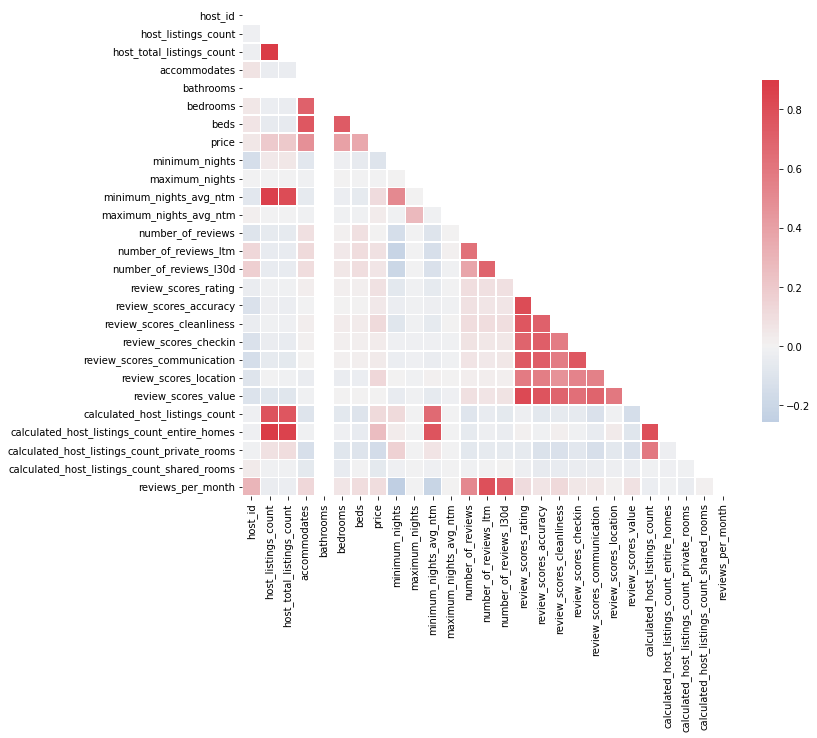

In [ ]:
## Correlation
import seaborn as sns
## citation - https://github.com/W4995-AML/aml-assignment-1-fall-2022-recurx/blob/main/ab5434_HW1_013_AML.ipynb

corr = data.corr()
r, c = corr.shape
corr_vals = corr.values
cols_list = list(corr.columns)
h_corr_cols = set()

for i in range(r):
    for j in range(i+1, c):
        if corr_vals[i][j] >= 0.8:
            h_corr_cols.add(cols_list[i])
            
print("high correlation: ", [h for h in h_corr_cols])

mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.9, center=0, square=True, linewidths=.7, cbar_kws={"shrink": .7})


# data exploration

# visualization


## host related (not host name and host about)

### host_id

In [ ]:
len(data.host_id.unique())

26292

### host_sinse

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimelike.py:1190: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


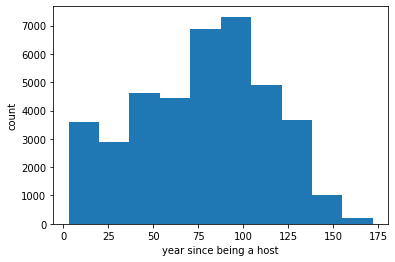

In [ ]:
from datetime import datetime
#np.ceil(-(pd.to_datetime(data.host_since,format='%m/%d/%y')-np.full(fill_value=pd.Timestamp(datetime.now()).today(),shape=len(data)))/np.timedelta64(1,'Y'))
preprosessed_host_since=np.ceil(-(pd.to_datetime(data.host_since,format='%m/%d/%y')-np.full(fill_value=pd.Timestamp(datetime.now()).today(),shape=len(data)))/np.timedelta64(1,'M'))
plt.hist(preprosessed_host_since)
plt.xlabel("year since being a host")
plt.ylabel("count")
plt.show()

### host location

In [ ]:
### nyc  and non nyc

In [ ]:
Preprocessed_host_location=[]
non_US=[]
non_NY=[]
NY=[]
NYC=[]
for i in range(len(data)):
  if not data.host_location.isnull().iloc[i]:
    a=data.host_location.iloc[i].split(", ")
    if len(a)!=2:
      if a[0]=='United States':
        Preprocessed_host_location.append("non-NY")
        non_NY.append(data.host_location.iloc[i])

      else:
        Preprocessed_host_location.append("non-US")
        non_US.append(data.host_location.iloc[i])
    else:
      if len(a[1])==2:
        if a[1]=='NY':
          if a[0]=="New York":
            Preprocessed_host_location.append("NYC")
            NYC.append(data.host_location.iloc[i])
          else:
            Preprocessed_host_location.append("NY")
            NY.append(data.host_location.iloc[i])
        else:
          Preprocessed_host_location.append("non-NY")
          non_NY.append(data.host_location.iloc[i])
      else:
        if a[1]=='United States':
          if a[0]=="New York":
            Preprocessed_host_location.append("NYC")
            NYC.append(data.host_location.iloc[i])
          else:
            Preprocessed_host_location.append("non-NY")
            non_NY.append(data.host_location.iloc[i])
        else:
          Preprocessed_host_location.append("non-US")
          non_US.append(data.host_location.iloc[i])
  else:
    Preprocessed_host_location.append(np.nan)

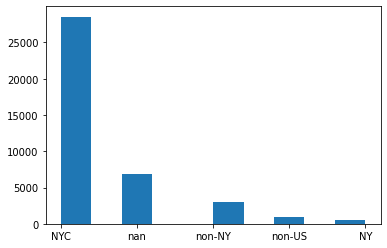

In [ ]:
plt.hist(Preprocessed_host_location)
plt.show()

### host response time

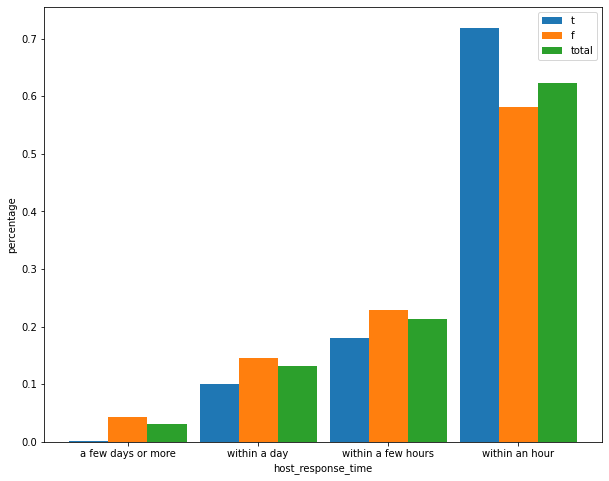

In [ ]:
data1=data.host_response_time.groupby([data.host_is_superhost,data.host_response_time]).count().reset_index(name='count')
percent=[]
for i in range(len(data1)):
  if data1.iloc[i].host_is_superhost=="t":
    percent.append(round(data1.iloc[i]["count"]/sum(data1.loc[data1.host_is_superhost=="t"]["count"]),4))
  else:
    percent.append(round(data1.iloc[i]["count"]/sum(data1.loc[data1.host_is_superhost=="f"]["count"]),4))
data1["percent"]=percent
t=data1.loc[data1.host_is_superhost=="t"]["percent"]
f=data1.loc[data1.host_is_superhost=="f"]["percent"]
total=list(data.host_response_time.value_counts()/len(data.loc[data.host_response_time.notnull()]))[::-1]
x=data1.loc[data1.host_is_superhost=="f"]["host_response_time"]
p=plt.figure(figsize=(10,8))
br1=range(len(t))
br2=[x + 0.3 for x in br1]
br3=[x + 0.3 for x in br2]
plt.bar(br1,t,label="t",width=0.3)
plt.bar(br2,f,label="f",width=0.3)
plt.bar(br3,total,label="total",width=0.3)
plt.xticks([r + 0.3 for r in range(len(t))],x)
plt.xlabel('host_response_time')
plt.ylabel('percentage')
plt.legend()
plt.show()

### host response rate

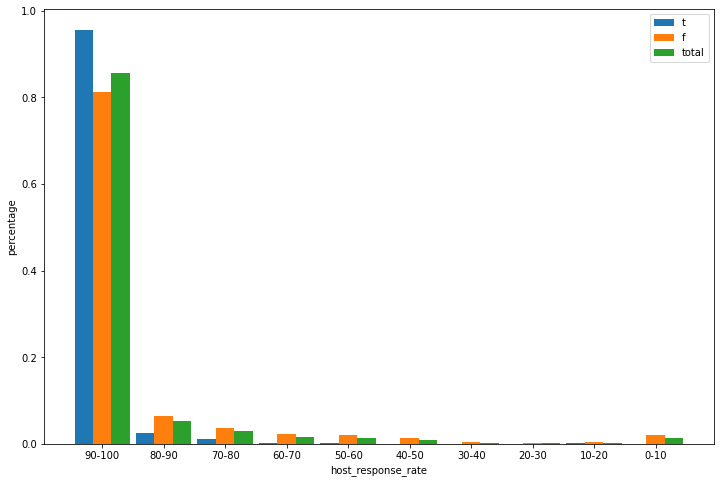

In [ ]:
data1=data.loc[data.host_response_rate.notnull()]
dict_response_rate={"90-100":0,"80-90":0,"70-80":0,"60-70":0,"50-60":0,"40-50":0,"30-40":0,"20-30":0,"10-20":10,"0-10":0}
dict_response_ratet={"90-100":0,"80-90":0,"70-80":0,"60-70":0,"50-60":0,"40-50":0,"30-40":0,"20-30":0,"10-20":10,"0-10":0}
dict_response_ratef={"90-100":0,"80-90":0,"70-80":0,"60-70":0,"50-60":0,"40-50":0,"30-40":0,"20-30":0,"10-20":10,"0-10":0}
for i in range(len(data1)):
  #print(i,data1.iloc[i].host_response_rate)
  if int(data1.iloc[i].host_response_rate[:-1])>=90:
    dict_response_rate["90-100"]+=1
    if data1.iloc[i].host_is_superhost=="t":
      dict_response_ratet["90-100"]+=1
    else:
      dict_response_ratef["90-100"]+=1
  elif int(data1.iloc[i].host_response_rate[:-1])>=80 and int(data1.iloc[i].host_response_rate[:-1])<90:
    dict_response_rate["80-90"]+=1
    if data1.iloc[i].host_is_superhost=="t":
      dict_response_ratet["80-90"]+=1
    else:
      dict_response_ratef["80-90"]+=1
  elif int(data1.iloc[i].host_response_rate[:-1])>=70 and int(data1.iloc[i].host_response_rate[:-1])<80:
    dict_response_rate["70-80"]+=1
    if data1.iloc[i].host_is_superhost=="t":
      dict_response_ratet["70-80"]+=1
    else:
      dict_response_ratef["70-80"]+=1
  elif int(data1.iloc[i].host_response_rate[:-1])>=60 and int(data1.iloc[i].host_response_rate[:-1])<70:
    dict_response_rate["60-70"]+=1
    if data1.iloc[i].host_is_superhost=="t":
      dict_response_ratet["60-70"]+=1
    else:
      dict_response_ratef["60-70"]+=1
  elif int(data1.iloc[i].host_response_rate[:-1])>=50 and int(data1.iloc[i].host_response_rate[:-1])<60:
    dict_response_rate["50-60"]+=1
    if data1.iloc[i].host_is_superhost=="t":
      dict_response_ratet["50-60"]+=1
    else:
      dict_response_ratef["50-60"]+=1
  elif int(data1.iloc[i].host_response_rate[:-1])>=40 and int(data1.iloc[i].host_response_rate[:-1])<50:
    dict_response_rate["40-50"]+=1
    if data1.iloc[i].host_is_superhost=="t":
      dict_response_ratet["40-50"]+=1
    else:
      dict_response_ratef["40-50"]+=1
  elif int(data1.iloc[i].host_response_rate[:-1])>=30 and int(data1.iloc[i].host_response_rate[:-1])<40:
    dict_response_rate["30-40"]+=1
    if data1.iloc[i].host_is_superhost=="t":
      dict_response_ratet["30-40"]+=1
    else:
      dict_response_ratef["30-40"]+=1
  elif int(data1.iloc[i].host_response_rate[:-1])>=20 and int(data1.iloc[i].host_response_rate[:-1])<30:
    dict_response_rate["20-30"]+=1
    if data1.iloc[i].host_is_superhost=="t":
      dict_response_ratet["20-30"]+=1
    else:
      dict_response_ratef["20-30"]+=1
  elif int(data1.iloc[i].host_response_rate[:-1])>=10 and int(data1.iloc[i].host_response_rate[:-1])<20:
    dict_response_rate["10-20"]+=1
    if data1.iloc[i].host_is_superhost=="t":
      dict_response_ratet["10-20"]+=1
    else:
      dict_response_ratef["10-20"]+=1
  else:
    dict_response_rate["0-10"]+=1
    if data1.iloc[i].host_is_superhost=="t":
      dict_response_ratet["0-10"]+=1
    else:
      dict_response_ratef["0-10"]+=1
f=[a/sum(dict_response_ratef.values()) for a in dict_response_ratef.values()]
t=[a/sum(dict_response_ratet.values()) for a in dict_response_ratet.values()]
total=[a/sum(dict_response_rate.values()) for a in dict_response_rate.values()]
p=plt.figure(figsize=(12,8))
br1=range(len(dict_response_ratet))
br2=[x + 0.3 for x in br1]
br3=[x + 0.3 for x in br2]
plt.bar(br1,t,label="t",width=0.3)
plt.bar(br2,f,label="f",width=0.3)
plt.bar(br3,total,label="total",width=0.3)
plt.xticks([r + 0.3 for r in range(len(dict_response_ratet))],
        dict_response_ratet.keys())
plt.xlabel('host_response_rate')
plt.ylabel('percentage')
plt.legend()
plt.show()

In [ ]:
preprocessed_host_response_rate=[]
for i in range(len(data)):
  if not data.host_response_rate.isnull().iloc[i]:
    preprocessed_host_response_rate.append(data.iloc[i].host_response_rate[:-1])
  else:
    preprocessed_host_response_rate.append(np.nan)


### host acceptance rate

In [ ]:
preprocessed_host_acceptance_rate=[]
preprocessed_host_acceptance_rate2=[]
dict_acceptance_rate={"90-100":0,"80-90":0,"70-80":0,"60-70":0,"50-60":0,"40-50":0,"30-40":0,"20-30":0,"10-20":10,"0-10":0}
dict_acceptance_ratet={"90-100":0,"80-90":0,"70-80":0,"60-70":0,"50-60":0,"40-50":0,"30-40":0,"20-30":0,"10-20":10,"0-10":0}
dict_acceptance_ratef={"90-100":0,"80-90":0,"70-80":0,"60-70":0,"50-60":0,"40-50":0,"30-40":0,"20-30":0,"10-20":10,"0-10":0}
for i in range(len(data)):
  if not data.host_acceptance_rate.isnull().iloc[i]:
    preprocessed_host_acceptance_rate2.append(data.iloc[i].host_acceptance_rate[:-1])
    if int(data.iloc[i].host_acceptance_rate[:-1])>=90:
      preprocessed_host_acceptance_rate.append("90-100")
      dict_acceptance_rate["90-100"]+=1
      if data.iloc[i].host_is_superhost=="t":
        dict_acceptance_ratet["90-100"]+=1
      else:
        dict_acceptance_ratef["90-100"]+=1
    elif int(data.iloc[i].host_acceptance_rate[:-1])>=80 and int(data.iloc[i].host_acceptance_rate[:-1])<90:
      preprocessed_host_acceptance_rate.append("80-90")
      dict_acceptance_rate["80-90"]+=1
      if data.iloc[i].host_is_superhost=="t":
        dict_acceptance_ratet["80-90"]+=1
      else:
        dict_acceptance_ratef["80-90"]+=1
    elif int(data.iloc[i].host_acceptance_rate[:-1])>=70 and int(data.iloc[i].host_acceptance_rate[:-1])<80:
      preprocessed_host_acceptance_rate.append("70-80")
      dict_acceptance_rate["70-80"]+=1
      if data.iloc[i].host_is_superhost=="t":
        dict_acceptance_ratet["70-80"]+=1
      else:
        dict_acceptance_ratef["70-80"]+=1
    elif int(data.iloc[i].host_acceptance_rate[:-1])>=60 and int(data.iloc[i].host_acceptance_rate[:-1])<70:
      preprocessed_host_acceptance_rate.append("60-70")
      dict_acceptance_rate["60-70"]+=1
      if data.iloc[i].host_is_superhost=="t":
        dict_acceptance_ratet["60-70"]+=1
      else:
        dict_acceptance_ratef["60-70"]+=1
    elif int(data.iloc[i].host_acceptance_rate[:-1])>=50 and int(data.iloc[i].host_acceptance_rate[:-1])<60:
      preprocessed_host_acceptance_rate.append("50-60")
      dict_acceptance_rate["50-60"]+=1
      if data.iloc[i].host_is_superhost=="t":
        dict_acceptance_ratet["50-60"]+=1
      else:
        dict_acceptance_ratef["50-60"]+=1
    elif int(data.iloc[i].host_acceptance_rate[:-1])>=40 and int(data.iloc[i].host_acceptance_rate[:-1])<50:
      preprocessed_host_acceptance_rate.append("40-50")
      dict_acceptance_rate["40-50"]+=1
      if data.iloc[i].host_is_superhost=="t":
        dict_acceptance_ratet["40-50"]+=1
      else:
        dict_acceptance_ratef["40-50"]+=1
    elif int(data.iloc[i].host_acceptance_rate[:-1])>=30 and int(data.iloc[i].host_acceptance_rate[:-1])<40:
      preprocessed_host_acceptance_rate.append("30-40")
      dict_acceptance_rate["30-40"]+=1
      if data.iloc[i].host_is_superhost=="t":
        dict_acceptance_ratet["30-40"]+=1
      else:
        dict_acceptance_ratef["30-40"]+=1
    elif int(data.iloc[i].host_acceptance_rate[:-1])>=20 and int(data.iloc[i].host_acceptance_rate[:-1])<30:
      preprocessed_host_acceptance_rate.append("20-30")
      dict_acceptance_rate["20-30"]+=1
      if data.iloc[i].host_is_superhost=="t":
        dict_acceptance_ratet["20-30"]+=1
      else:
        dict_acceptance_ratef["20-30"]+=1
    elif int(data.iloc[i].host_acceptance_rate[:-1])>=10 and int(data.iloc[i].host_acceptance_rate[:-1])<20:
      preprocessed_host_acceptance_rate.append("10-20")
      dict_acceptance_rate["10-20"]+=1
      if data.iloc[i].host_is_superhost=="t":
        dict_acceptance_ratet["10-20"]+=1
      else:
        dict_acceptance_ratef["10-20"]+=1
    elif int(data.iloc[i].host_acceptance_rate[:-1])>=0 and int(data.iloc[i].host_acceptance_rate[:-1])<10:
      preprocessed_host_acceptance_rate.append("0-10")
      dict_acceptance_rate["0-10"]+=1
      if data.iloc[i].host_is_superhost=="t":
        dict_acceptance_ratet["0-10"]+=1
      else:
        dict_acceptance_ratef["0-10"]+=1
  else:
    preprocessed_host_acceptance_rate2.append(np.nan)
    preprocessed_host_acceptance_rate.append(np.nan)

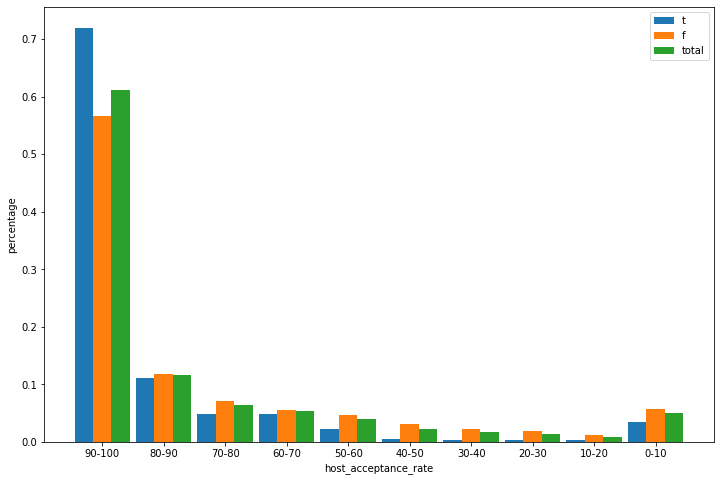

In [ ]:
f=[a/sum(dict_acceptance_ratef.values()) for a in dict_acceptance_ratef.values()]
t=[a/sum(dict_acceptance_ratet.values()) for a in dict_acceptance_ratet.values()]
total=[a/sum(dict_acceptance_rate.values()) for a in dict_acceptance_rate.values()]
p=plt.figure(figsize=(12,8))
br1=range(len(dict_acceptance_ratet))
br2=[x + 0.3 for x in br1]
br3=[x + 0.3 for x in br2]
plt.bar(br1,t,label="t",width=0.3)
plt.bar(br2,f,label="f",width=0.3)
plt.bar(br3,total,label="total",width=0.3)
plt.xticks([r + 0.3 for r in range(len(dict_acceptance_ratet))],
        dict_acceptance_ratet.keys())
plt.xlabel('host_acceptance_rate')
plt.ylabel('percentage')
plt.legend()
plt.show()

### host_is_superhost

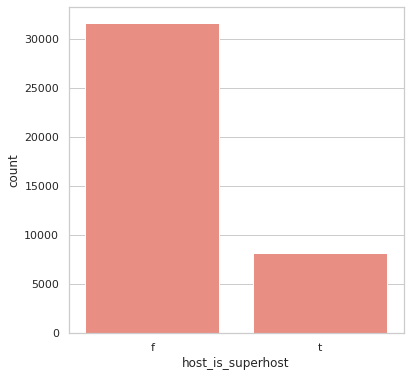

In [ ]:
# data.host_is_superhost.hist()
# plt.xlabel("host_is_superhost")
# plt.ylabel("count")
# plt.show()

sns.set_style("whitegrid")
plt.figure(figsize=(6,6))
sns.countplot(data=data, x="host_is_superhost", color="salmon")
plt.show()

### host listings count

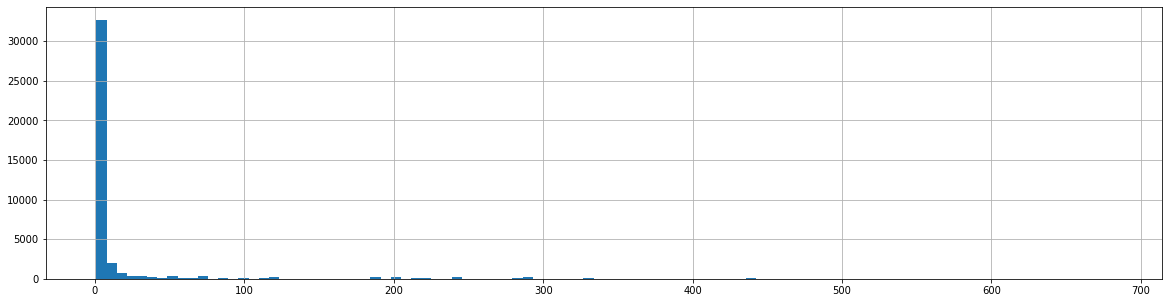

In [ ]:
f=plt.figure(figsize=(20,5))
data.loc[data.host_listings_count<=1000].host_listings_count.hist(bins=100)
plt.show()

### host total listing count

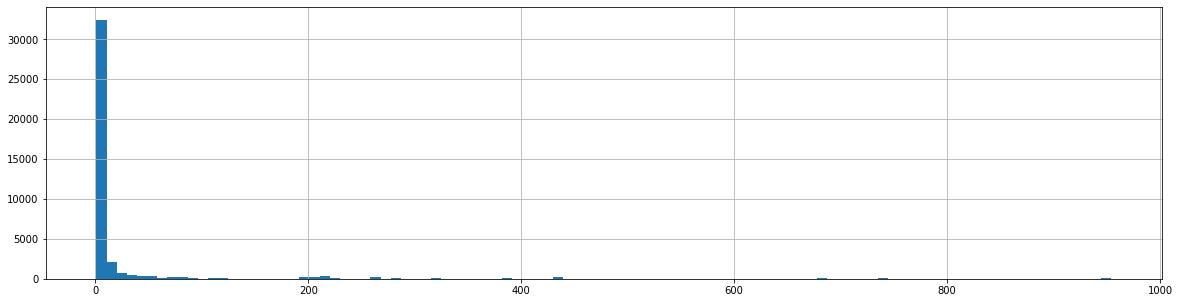

In [ ]:
f=plt.figure(figsize=(20,5))
data.loc[data.host_total_listings_count<=1000].host_total_listings_count.hist(bins=100)
plt.show()

### host_verifications

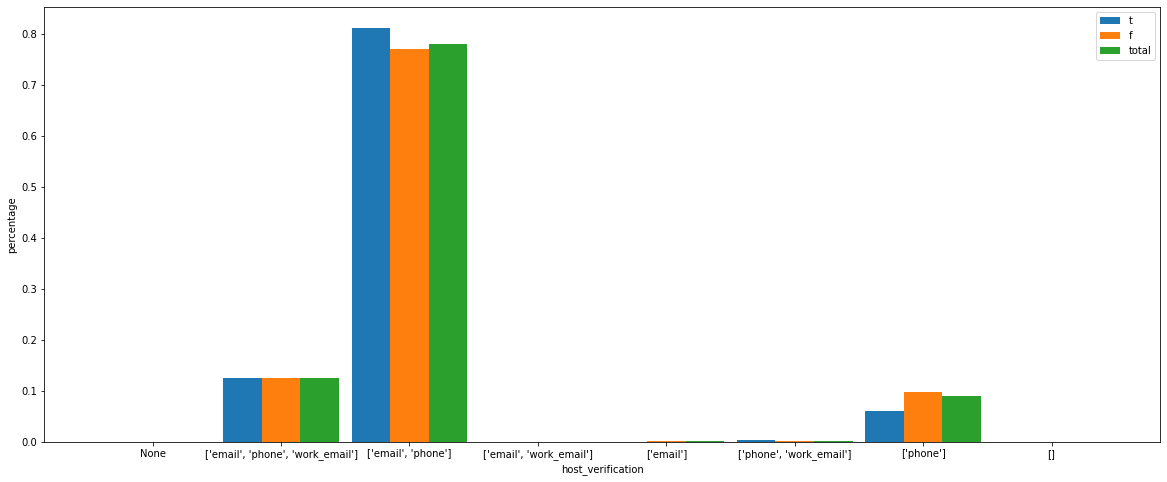

In [ ]:
from ast import Continue
email_list=[]
phone_list=[]
work_email_list=[]
for i in range(len(data)):
  if data.iloc[i].host_verifications=="['email', 'phone']":
    email_list.append(1)
    phone_list.append(1)
    work_email_list.append(0)
  elif data.iloc[i].host_verifications=="['email', 'phone', 'work_email']":
    email_list.append(1)
    phone_list.append(1)
    work_email_list.append(1)
  elif data.iloc[i].host_verifications=="['phone']":
    email_list.append(0)
    phone_list.append(1)
    work_email_list.append(0)
  elif data.iloc[i].host_verifications=="['phone', 'work_email']":
    email_list.append(0)
    phone_list.append(1)
    work_email_list.append(1)
  elif data.iloc[i].host_verifications=="['email']":
    email_list.append(1)
    phone_list.append(0)
    work_email_list.append(0)
  elif data.iloc[i].host_verifications=="None":
    email_list.append(0)
    phone_list.append(0)
    work_email_list.append(0)
  elif data.iloc[i].host_verifications=="[]":
    email_list.append(0)
    phone_list.append(0)
    work_email_list.append(0) 
  elif data.iloc[i].host_verifications=="['email', 'work_email']":
    email_list.append(1)
    phone_list.append(0)
    work_email_list.append(1)
data1=pd.DataFrame()
data1["host_verification_email"]=email_list
data1["host_verification_phone"]=phone_list
data1["host_verification_work_email"]=work_email_list
data1["host_is_superhost"]=data.host_is_superhost
data1=data.groupby([data.host_is_superhost,data.host_verifications]).host_verifications.count().reset_index(name="count")
percent=[]
for i in range(len(data1)):
  if data1.iloc[i].host_is_superhost=="t":
    percent.append(round(data1.iloc[i]["count"]/sum(data1.loc[data1.host_is_superhost=="t"]["count"]),4))
  else:
    percent.append(round(data1.iloc[i]["count"]/sum(data1.loc[data1.host_is_superhost=="f"]["count"]),4))
data1["percent"]=percent
f={}
for i in range(len(data1.loc[data1.host_is_superhost=="f"])):
  f[data1.host_verifications.iloc[i]]=data1.iloc[i]["percent"]
t={}
for i in f.keys():
  if len(data1.loc[(data1.host_verifications==i) & (data1.host_is_superhost=="t")])==1:
    t[i]=float(data1.loc[(data1.host_verifications==i) & (data1.host_is_superhost=="t")]["percent"])
  else:
    t[i]=0
total=list(data.host_verifications.value_counts().sort_index()/len(data))
x=t.keys()
p=plt.figure(figsize=(20,8))
br1=range(len(t))
br2=[x + 0.3 for x in br1]
br3=[x + 0.3 for x in br2]
plt.bar(br1,t.values(),label="t",width=0.3)
plt.bar(br2,f.values(),label="f",width=0.3)
plt.bar(br3,total,label="total",width=0.3)
plt.xticks([r + 0.3 for r in range(len(t))],x)
plt.xlabel('host_verification')
plt.ylabel('percentage')
plt.legend()
plt.show()

### host_has_profile_pic

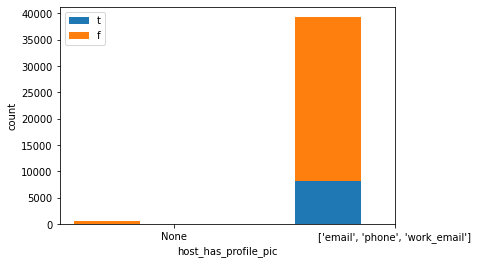

In [ ]:
data1=data.groupby([data.host_is_superhost,data.host_has_profile_pic]).host_has_profile_pic.count().reset_index(name='count')
t=data1.loc[data1.host_is_superhost=="t"]["count"]
f=data1.loc[data1.host_is_superhost=="f"]["count"]
br1=range(len(t))
plt.bar(br1,t,label="t",width=0.3)
plt.bar(br1,f,label="f",width=0.3,bottom=t)
plt.xticks([r + 0.3 for r in range(len(t))],x)
plt.xlabel('host_has_profile_pic')
plt.ylabel('count')
plt.legend()
plt.show()

### host_identity_verified

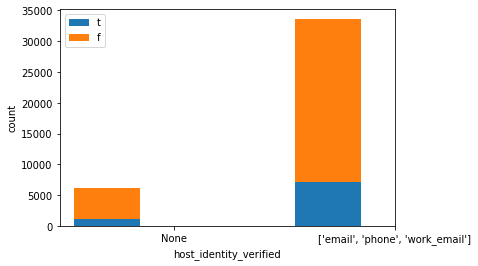

In [ ]:
data1=data.groupby([data.host_is_superhost,data.host_identity_verified]).host_identity_verified.count().reset_index(name='count')
t=data1.loc[data1.host_is_superhost=="t"]["count"]
f=data1.loc[data1.host_is_superhost=="f"]["count"]
br1=range(len(t))
plt.bar(br1,t,label="t",width=0.3)
plt.bar(br1,f,label="f",width=0.3,bottom=t)
plt.xticks([r + 0.3 for r in range(len(t))],x)
plt.xlabel('host_identity_verified')
plt.ylabel('count')
plt.legend()
plt.show()

## neighbourhood_cleansed - price


Listing with price >= $1500:  258 




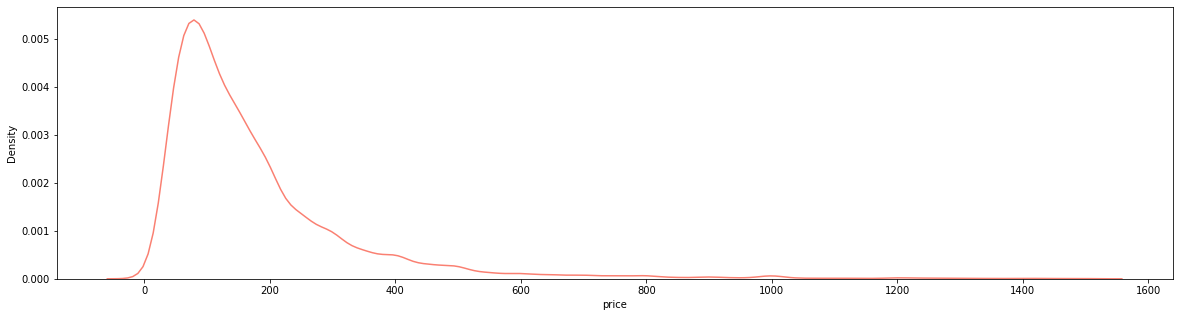

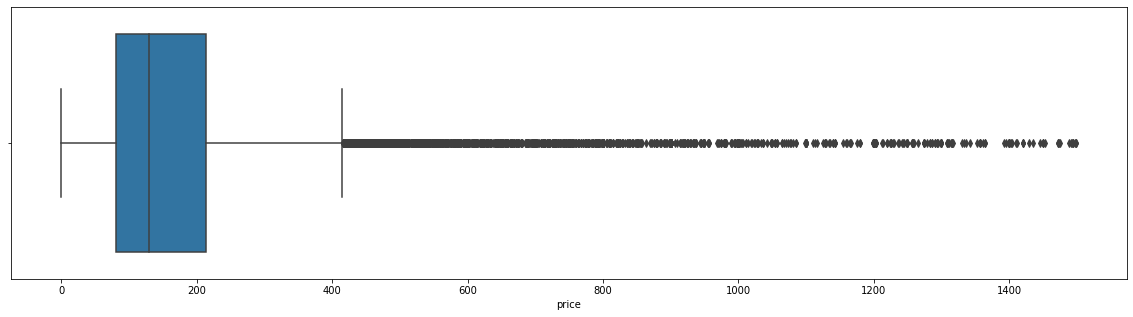

In [ ]:
## Price distribution: Removed rows where price >= 1500 (258 listings), some plotting on price
import seaborn as sns



count = 0
for price in data['price']:
  if price >= 1500:
    count += 1

print("\nListing with price >= $1500: ", count, "\n\n")

data_price_1500 = data[data.price < 1500]

plt.figure(figsize=(20,5))
sns.kdeplot(data=data_price_1500, x="price", color="salmon")
plt.show()

plt.figure(figsize=(20,5))
sns.boxplot(x=data_price_1500["price"])
plt.show()



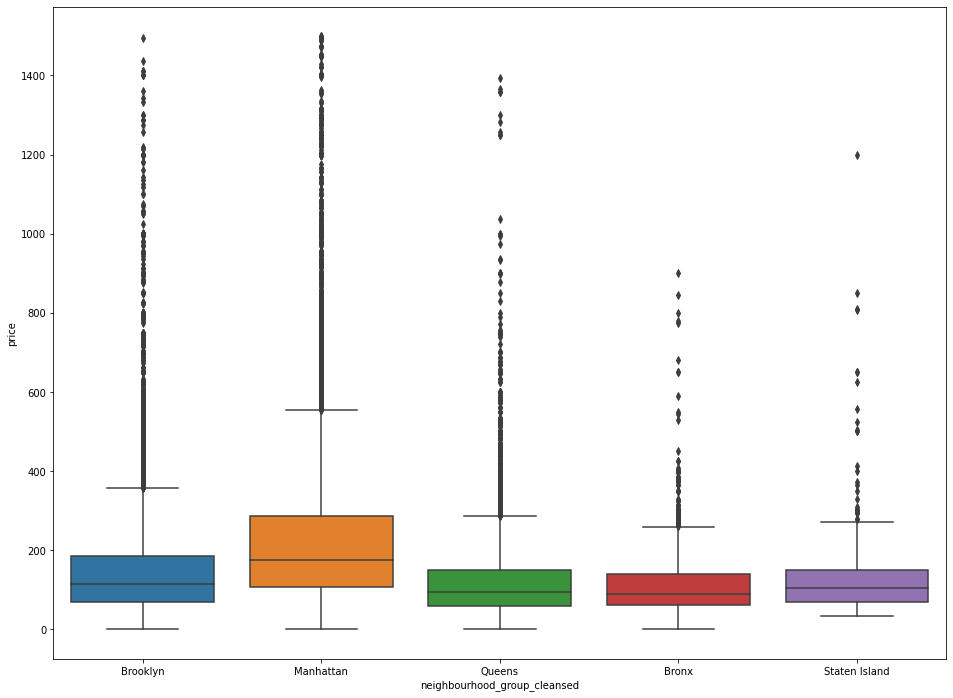

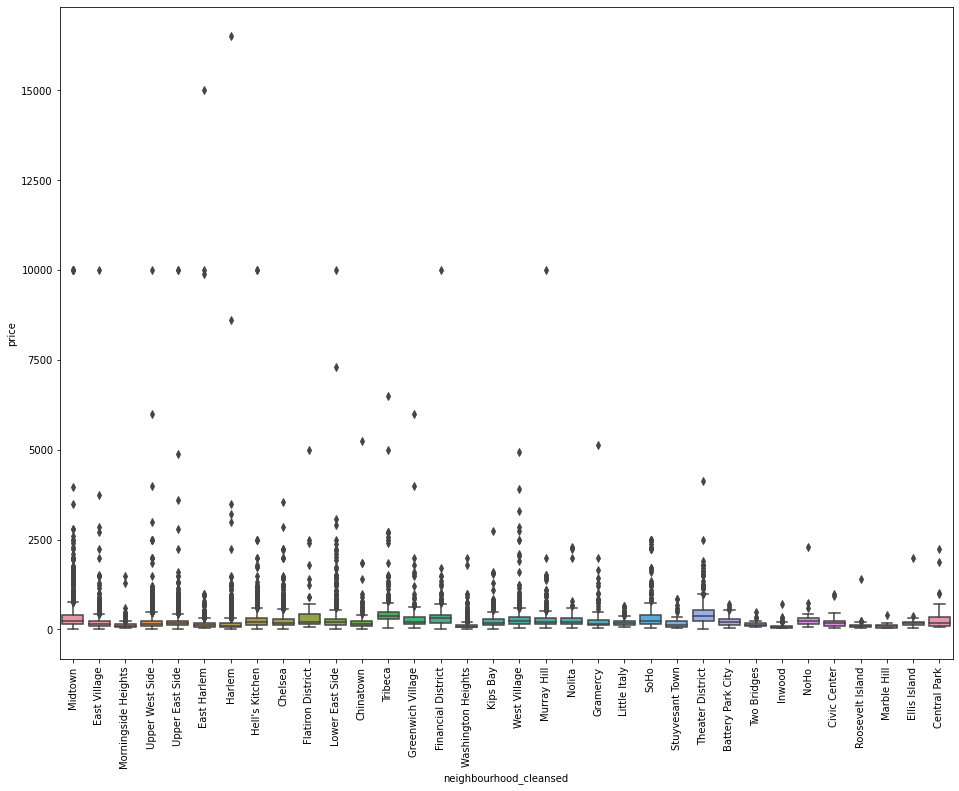

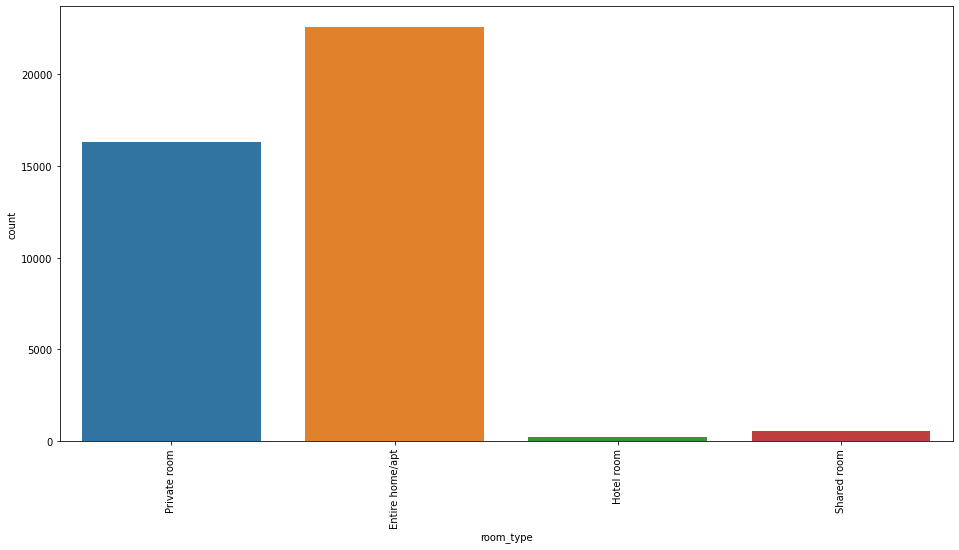

In [ ]:
## Categorical variables: neighbourhood_group_cleansed, property_type, room_type

plt.figure(figsize=(16,12))
sns.boxplot(y=data["price"], x=data["neighbourhood_group_cleansed"])
plt.show()

print("\n\n")

data_neighbourhood_manhattan = data[data.neighbourhood_group_cleansed == "Manhattan"]

plt.figure(figsize=(16,12))
ax = sns.boxplot(y=data_neighbourhood_manhattan["price"], x=data_neighbourhood_manhattan["neighbourhood_cleansed"])
ax.tick_params(axis='x', rotation=90)
plt.show()

print("\n\n")

plt.figure(figsize=(16,8))
# ax = sns.boxplot(y=data_price_1500["price"], x=data_price_1500["property_type"])
ax = sns.countplot(x=data["room_type"])
ax.tick_params(axis='x', rotation=90)
plt.show()

[ 1. nan  5.  2.  3.  4.  8.  6.  7. 11.  9. 13.]
[ 1. 10.  2.  5.  3.  8.  4.  6. nan  9.  7. 18. 12. 11. 21. 13. 24. 14.]
[ 2  1 16  4  3  5  7 12  6  9  8 10 11 14 15 13  0]


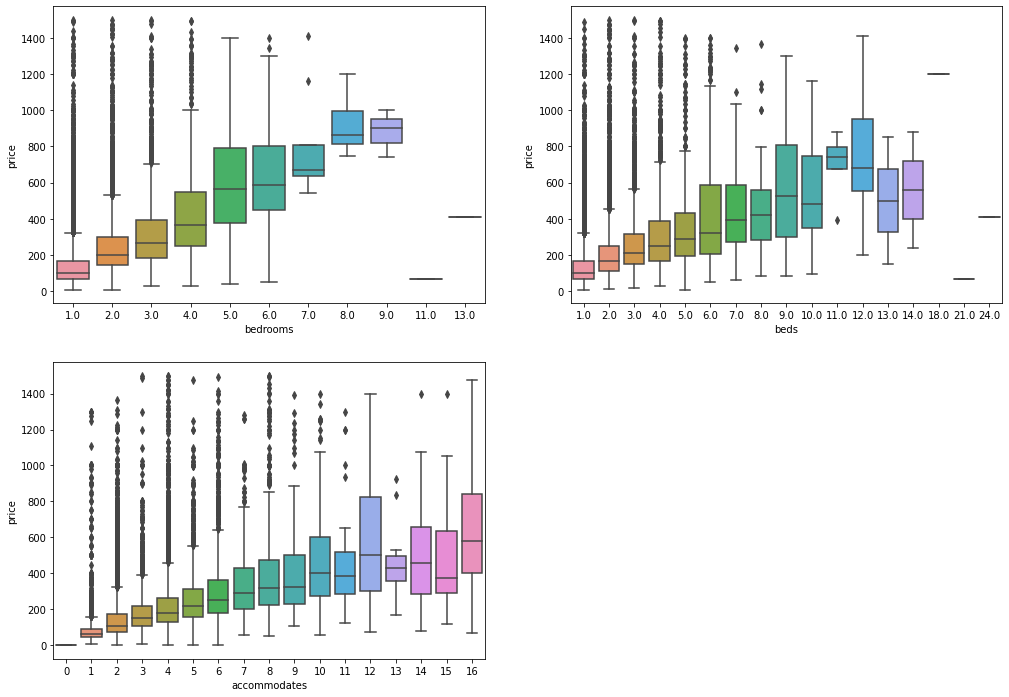

In [ ]:
## bedrooms, beds, accomodates
print(data_price_1500['bedrooms'].unique())
print(data_price_1500['beds'].unique())
print(data_price_1500['accommodates'].unique())

plt.figure(figsize=(17,12))

plt.subplot(2, 2, 1)
sns.boxplot(data=data_price_1500, x="bedrooms", y="price")

plt.subplot(2, 2, 2)
sns.boxplot(data=data_price_1500, x="beds", y="price")

plt.subplot(2, 2, 3)
sns.boxplot(data=data_price_1500, x="accommodates", y="price")

## Min nights - number_of_reviews_l30d

### minimum nights 

{'<=7 days': 19266, '7 to 14 days': 695, '14 to 21 days': 401, '21 to 28 days': 298, '>28 days': 19221}


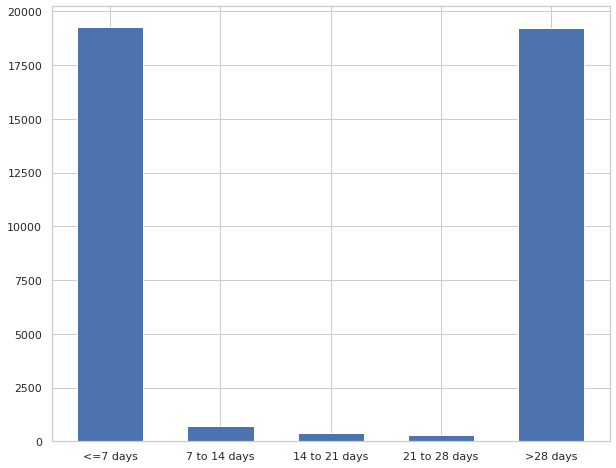

In [ ]:
# minimum_nights (general)
data_mn = data[data.minimum_nights.notnull()]
min_nights_one ={"<=7 days":0,"7 to 14 days":0,"14 to 21 days":0,"21 to 28 days":0, ">28 days":0}
for i in range(len(data_mn)):
  if data_mn.iloc[i].minimum_nights<=7:
    min_nights_one["<=7 days"]+=1
  elif data_mn.iloc[i].minimum_nights>7 and data_mn.iloc[i].minimum_nights<=14:
    min_nights_one["7 to 14 days"]+=1
  elif data_mn.iloc[i].minimum_nights>14 and data_mn.iloc[i].minimum_nights<=21:
    min_nights_one["14 to 21 days"]+=1
  elif data_mn.iloc[i].minimum_nights>21 and data_mn.iloc[i].minimum_nights<=28:
    min_nights_one["21 to 28 days"]+=1
  elif data_mn.iloc[i].minimum_nights>28:
    min_nights_one[">28 days"]+=1

print(min_nights_one)
plt.figure(figsize =(10, 8))
plt.bar(min_nights_one.keys(),min_nights_one.values(),width = 0.6)
plt.show()

{'1 day': 6518, '2 days': 5127, '3 days': 3509, '4 days': 1335, '5 days': 1456, '6 days': 395, '7 days': 926}


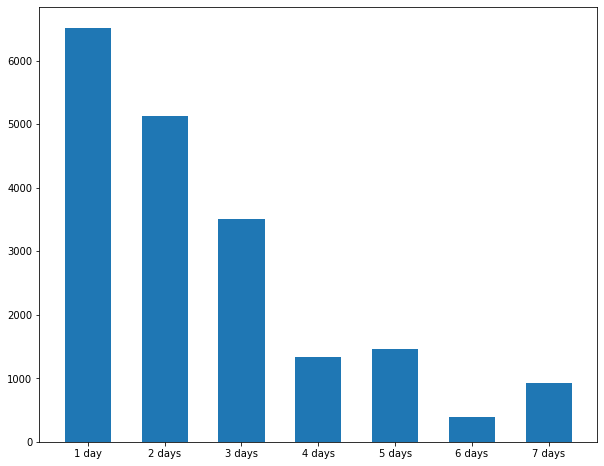

In [ ]:
#minimum_nights (<=7 days)
data_l7 = data[data.minimum_nights<=7]
min_nights_two ={"1 day":0,"2 days":0,"3 days":0,"4 days":0,"5 days":0,"6 days":0,"7 days":0}
for i in range(len(data_l7)):
  if data_l7.iloc[i].minimum_nights==1:
    min_nights_two["1 day"]+=1
  elif data_l7.iloc[i].minimum_nights==2:
    min_nights_two["2 days"]+=1
  elif data_l7.iloc[i].minimum_nights==3:
    min_nights_two["3 days"]+=1
  elif data_l7.iloc[i].minimum_nights==4:
    min_nights_two["4 days"]+=1
  elif data_l7.iloc[i].minimum_nights==5:
    min_nights_two["5 days"]+=1
  elif data_l7.iloc[i].minimum_nights==6:
    min_nights_two["6 days"]+=1
  else:
    min_nights_two["7 days"]+=1


print(min_nights_two)
plt.figure(figsize =(10, 8))
plt.bar(min_nights_two.keys(),min_nights_two.values(),width = 0.6)
plt.show()

### maximum nights

{'<30 days': 8622, '30 to 60 days': 2601, '60 to 90 days': 1515, '90 to 180 days': 1419, '180 to 365 days': 7523, '365 to 730 days': 293, 'more than 730 days': 17908}


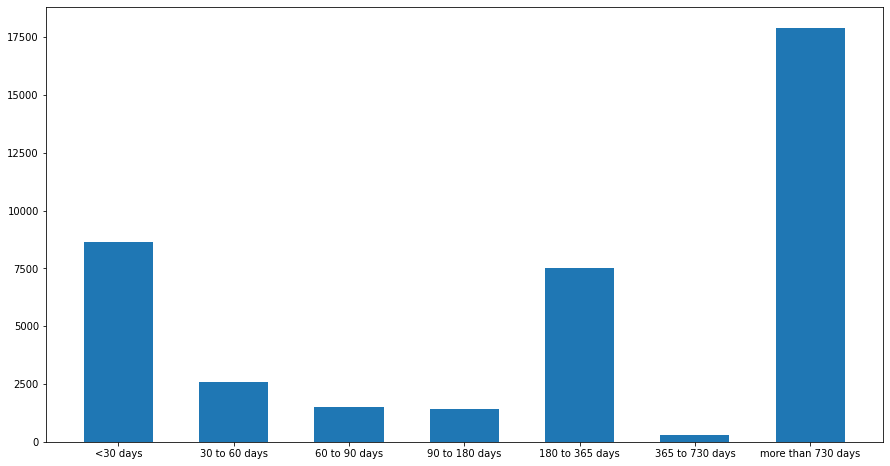

In [ ]:
# max_nights 
data_max = data[data.maximum_nights.notnull()]
max_nights_one ={"<30 days":0,"30 to 60 days":0,"60 to 90 days":0,"90 to 180 days":0,"180 to 365 days":0,"365 to 730 days":0,"more than 730 days":0}
for i in range(len(data_max)):
  if data_max.iloc[i].maximum_nights<=30:
    max_nights_one["<=30 days"]+=1
  elif data_max.iloc[i].maximum_nights>30 and data_max.iloc[i].maximum_nights<=60:
    max_nights_one["30 to 60 days"]+=1
  elif data_max.iloc[i].maximum_nights>60 and data_max.iloc[i].maximum_nights<=90:
    max_nights_one["60 to 90 days"]+=1
  elif data_max.iloc[i].maximum_nights>90 and data_max.iloc[i].maximum_nights<=180:
    max_nights_one["90 to 180 days"]+=1
  elif data_max.iloc[i].maximum_nights>180 and data_max.iloc[i].maximum_nights<=365:
    max_nights_one["180 to 365 days"]+=1
  elif data_max.iloc[i].maximum_nights>365 and data_max.iloc[i].maximum_nights<=730:
    max_nights_one["365 to 730 days"]+=1
  else:
    max_nights_one["more than 730 days"]+=1

print(max_nights_one)
plt.figure(figsize =(15, 8))
plt.bar(max_nights_one.keys(),max_nights_one.values(),width = 0.6)
plt.show()

{'<=7 days': 19101, '7 to 14 days': 775, '14 to 21 days': 428, '21 to 28 days': 356, '>28 days': 19207}


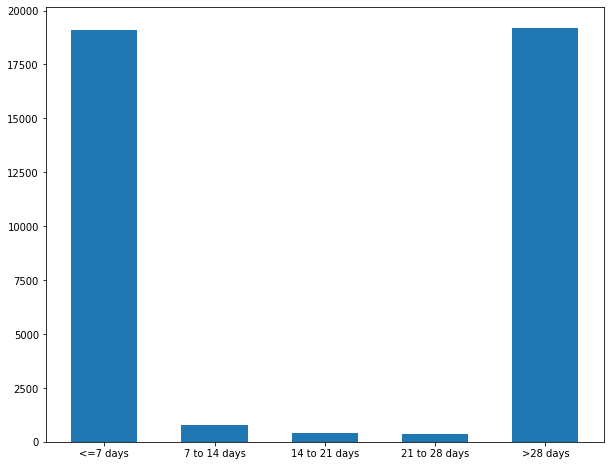

In [ ]:
# minimum_nights_avg_ntm

data_mnan = data[data.minimum_nights_avg_ntm.notnull()]
mnan_one ={"<=7 days":0,"7 to 14 days":0,"14 to 21 days":0,"21 to 28 days":0, ">28 days":0}
for i in range(len(data_mnan)):
  if data_mnan.iloc[i].minimum_nights_avg_ntm<=7:
    mnan_one["<=7 days"]+=1
  elif data_mnan.iloc[i].minimum_nights_avg_ntm>7 and data_mnan.iloc[i].minimum_nights_avg_ntm<=14:
    mnan_one["7 to 14 days"]+=1
  elif data_mnan.iloc[i].minimum_nights_avg_ntm>14 and data_mnan.iloc[i].minimum_nights_avg_ntm<=21:
    mnan_one["14 to 21 days"]+=1
  elif data_mnan.iloc[i].minimum_nights_avg_ntm>21 and data_mnan.iloc[i].minimum_nights_avg_ntm<=28:
    mnan_one["21 to 28 days"]+=1
  else:
    mnan_one[">28 days"]+=1

print(mnan_one)
plt.figure(figsize =(10, 8))
plt.bar(mnan_one.keys(),mnan_one.values(),width = 0.6)
plt.show()

{'<=30 days': 5456, '30 to 60 days': 1730, '60 to 90 days': 972, '90 to 180 days': 1048, '180 to 365 days': 5420, '365 to 730 days': 246, 'more than 730 days': 24995}


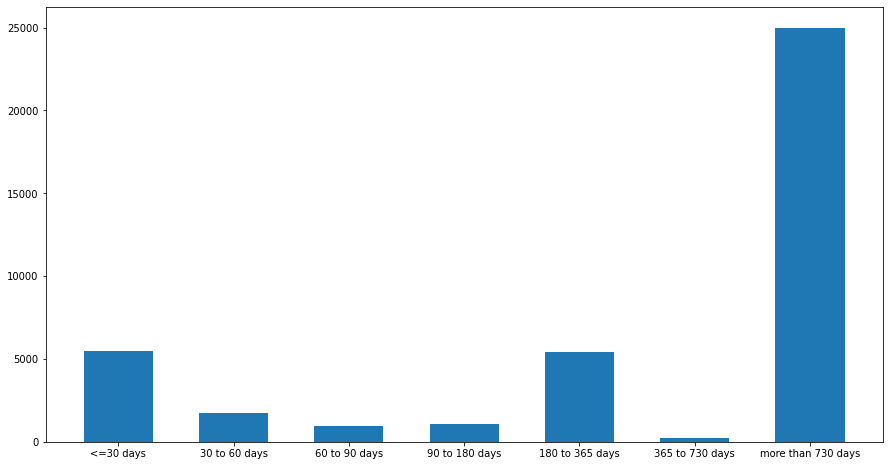

In [ ]:
# maximum_nights_avg_ntm

data_mxan = data[data.maximum_nights_avg_ntm.notnull()]
mxan_one ={"<=30 days":0,"30 to 60 days":0,"60 to 90 days":0,"90 to 180 days":0,"180 to 365 days":0,"365 to 730 days":0,"more than 730 days":0}
for i in range(len(data_mxan)):
  if data_mxan.iloc[i].maximum_nights_avg_ntm<=30:
    mxan_one["<=30 days"]+=1
  elif data_mxan.iloc[i].maximum_nights_avg_ntm>30 and data_mxan.iloc[i].maximum_nights_avg_ntm<=60:
    mxan_one["30 to 60 days"]+=1
  elif data_mxan.iloc[i].maximum_nights_avg_ntm>60 and data_mxan.iloc[i].maximum_nights_avg_ntm<=90:
    mxan_one["60 to 90 days"]+=1
  elif data_mxan.iloc[i].maximum_nights_avg_ntm>90 and data_mxan.iloc[i].maximum_nights_avg_ntm<=180:
    mxan_one["90 to 180 days"]+=1
  elif data_mxan.iloc[i].maximum_nights_avg_ntm>180 and data_mxan.iloc[i].maximum_nights_avg_ntm<=365:
    mxan_one["180 to 365 days"]+=1
  elif data_mxan.iloc[i].maximum_nights_avg_ntm>365 and data_mxan.iloc[i].maximum_nights_avg_ntm<=730:
    mxan_one["365 to 730 days"]+=1
  else:
    mxan_one["more than 730 days"]+=1

print(mxan_one)
plt.figure(figsize =(15, 8))
plt.bar(mxan_one.keys(),mxan_one.values(),width = 0.6)
plt.show()

### number of reviews

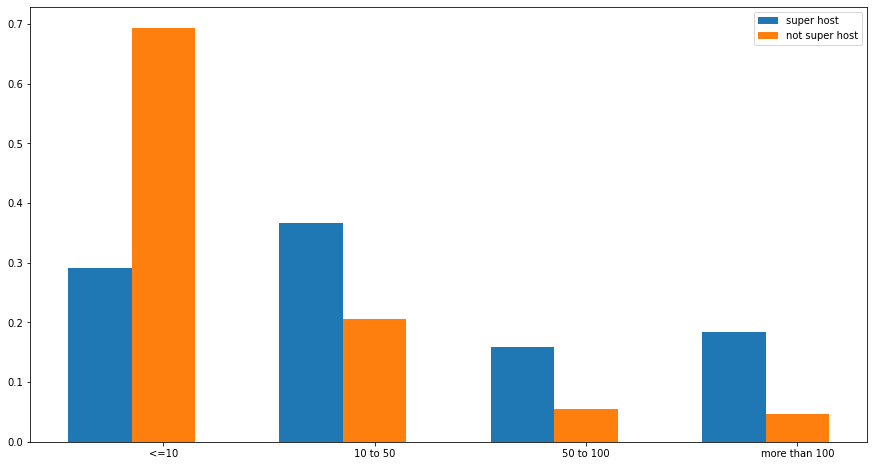

In [ ]:
# number_of_reviews & superhost
data_review=data[data.number_of_reviews.notnull()]
review_t ={"<=10":0,"10 to 50":0,"50 to 100":0,"more than 100":0}
review_f ={"<=10":0,"10 to 50":0,"50 to 100":0,"more than 100":0}

for i in range(len(data_review)):
  if data_review.iloc[i].number_of_reviews<=10:
    if data_review.iloc[i].host_is_superhost=='t':
      review_t["<=10"]+=1
    else:
      review_f["<=10"]+=1
  elif data_review.iloc[i].number_of_reviews>10 and data_review.iloc[i].number_of_reviews<=50:
    if data_review.iloc[i].host_is_superhost=='t':
      review_t["10 to 50"]+=1
    else:
      review_f["10 to 50"]+=1
  elif data_review.iloc[i].number_of_reviews>50 and data_review.iloc[i].number_of_reviews<=100:
    if data_review.iloc[i].host_is_superhost=='t':
      review_t["50 to 100"]+=1
    else:
      review_f["50 to 100"]+=1
  else:
    if data_review.iloc[i].host_is_superhost=='t':
      review_t["more than 100"]+=1
    else:
      review_f["more than 100"]+=1


plt.figure(figsize =(15, 8))
review_t_new=[a/sum(review_t.values()) for a in review_t.values()]
review_f_new=[a/sum(review_f.values()) for a in review_f.values()]
bar1=range(len(review_t))
bar2=[i+0.3 for i in bar1]
plt.bar(bar1,review_t_new,label='super host',width = 0.3)
plt.bar(bar2,review_f_new,label='not super host',width = 0.3)
plt.xticks([r+0.3 for r in range(len(review_t))],review_t.keys())
plt.legend()
plt.show()

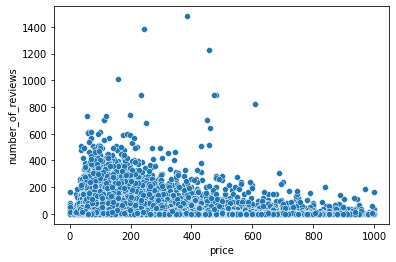

In [ ]:
# number_of_reviews & price 

import seaborn as sns
data['price'] = data['price'].replace('[\$,]', '', regex=True).astype(float)
data_price_1000 = data[data.price < 1000]
sns.scatterplot(y=data_price_1000['number_of_reviews'],x=data_price_1000["price"])

### number_of_reviews_ltm

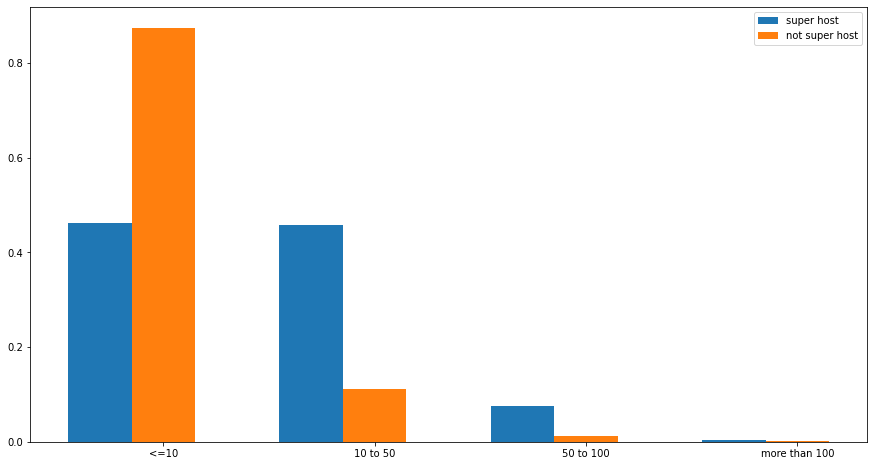

In [ ]:
# number_of_reviews_ltm
data_reviewl=data[data.number_of_reviews_ltm.notnull()]
reviewl_t ={"<=10":0,"10 to 50":0,"50 to 100":0,"more than 100":0}
reviewl_f ={"<=10":0,"10 to 50":0,"50 to 100":0,"more than 100":0}

for i in range(len(data_reviewl)):
  if data_reviewl.iloc[i].number_of_reviews_ltm<=10:
    if data_reviewl.iloc[i].host_is_superhost=='t':
      reviewl_t["<=10"]+=1
    else:
      reviewl_f["<=10"]+=1
  elif data_reviewl.iloc[i].number_of_reviews_ltm>10 and data_reviewl.iloc[i].number_of_reviews_ltm<=50:
    if data_reviewl.iloc[i].host_is_superhost=='t':
      reviewl_t["10 to 50"]+=1
    else:
      reviewl_f["10 to 50"]+=1
  elif data_reviewl.iloc[i].number_of_reviews_ltm>50 and data_reviewl.iloc[i].number_of_reviews_ltm<=100:
    if data_reviewl.iloc[i].host_is_superhost=='t':
      reviewl_t["50 to 100"]+=1
    else:
      reviewl_f["50 to 100"]+=1
  else:
    if data_reviewl.iloc[i].host_is_superhost=='t':
      reviewl_t["more than 100"]+=1
    else:
      reviewl_f["more than 100"]+=1


plt.figure(figsize =(15, 8))
reviewl_t_new=[a/sum(reviewl_t.values()) for a in reviewl_t.values()]
reviewl_f_new=[a/sum(reviewl_f.values()) for a in reviewl_f.values()]
bar1=range(len(reviewl_t))
bar2=[i+0.3 for i in bar1]
plt.bar(bar1,reviewl_t_new,label='super host',width = 0.3)
plt.bar(bar2,reviewl_f_new,label='not super host',width = 0.3)
plt.xticks([r+0.3 for r in range(len(reviewl_t))],reviewl_t.keys())
plt.legend()
plt.show()

### number_of_reviews_l30d

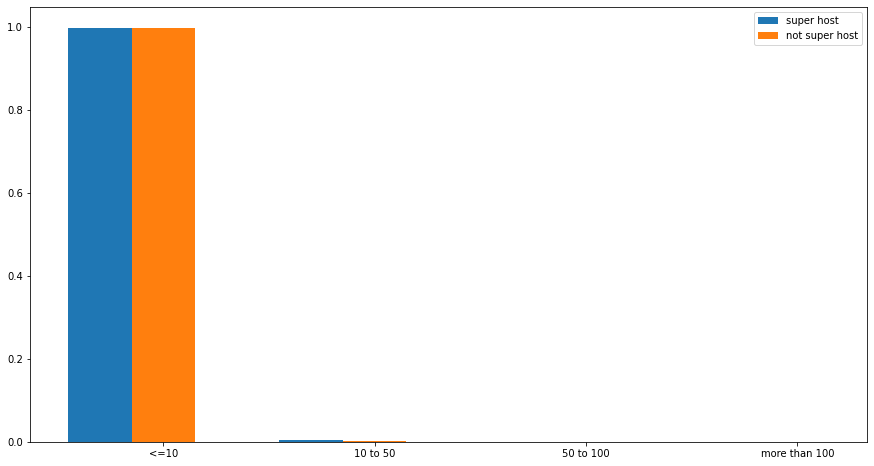

In [ ]:
# number_of_reviews_l30d
data_reviewl30=data[data.number_of_reviews_l30d.notnull()]
reviewl30_t ={"<=10":0,"10 to 50":0,"50 to 100":0,"more than 100":0}
reviewl30_f ={"<=10":0,"10 to 50":0,"50 to 100":0,"more than 100":0}

for i in range(len(data_reviewl30)):
  if data_reviewl30.iloc[i].number_of_reviews_l30d<=10:
    if data_reviewl30.iloc[i].host_is_superhost=='t':
      reviewl30_t["<=10"]+=1
    else:
      reviewl30_f["<=10"]+=1
  elif data_reviewl30.iloc[i].number_of_reviews_l30d>10 and data_reviewl30.iloc[i].number_of_reviews_l30d<=50:
    if data_reviewl30.iloc[i].host_is_superhost=='t':
      reviewl30_t["10 to 50"]+=1
    else:
      reviewl30_f["10 to 50"]+=1
  elif data_reviewl30.iloc[i].number_of_reviews_l30d>50 and data_reviewl30.iloc[i].number_of_reviews_l30d<=100:
    if data_reviewl30.iloc[i].host_is_superhost=='t':
      reviewl30_t["50 to 100"]+=1
    else:
      reviewl30_f["50 to 100"]+=1
  else:
    if data_reviewl30.iloc[i].host_is_superhost=='t':
      reviewl30_t["more than 100"]+=1
    else:
      reviewl30_f["more than 100"]+=1


plt.figure(figsize =(15, 8))
reviewl30_t_new=[a/sum(reviewl30_t.values()) for a in reviewl30_t.values()]
reviewl30_f_new=[a/sum(reviewl30_f.values()) for a in reviewl30_f.values()]
bar1=range(len(reviewl30_t))
bar2=[i+0.3 for i in bar1]
plt.bar(bar1,reviewl30_t_new,label='super host',width = 0.3)
plt.bar(bar2,reviewl30_f_new,label='not super host',width = 0.3)
plt.xticks([r+0.3 for r in range(len(reviewl30_t))],reviewl30_t.keys())
plt.legend()
plt.show()

# review_scores_rating to review_scores_value

In [ ]:
import seaborn as sns

In [ ]:
data_review = data[["review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value"]]
data_review

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,4.89,4.88,5.00,5.00,5.00,4.75,4.88
1,4.68,4.73,4.63,4.77,4.80,4.81,4.40
2,4.52,4.22,4.09,4.91,4.91,4.47,4.52
3,4.42,4.64,4.36,4.82,5.00,4.82,4.55
4,5.00,5.00,5.00,5.00,5.00,4.67,5.00
...,...,...,...,...,...,...,...
39876,4.91,4.97,4.88,4.97,5.00,4.94,4.88
39877,4.79,4.92,4.75,5.00,4.96,4.81,4.85
39878,4.45,4.64,4.27,4.64,4.36,4.36,4.55
39879,NaN,NaN,NaN,NaN,NaN,NaN,NaN


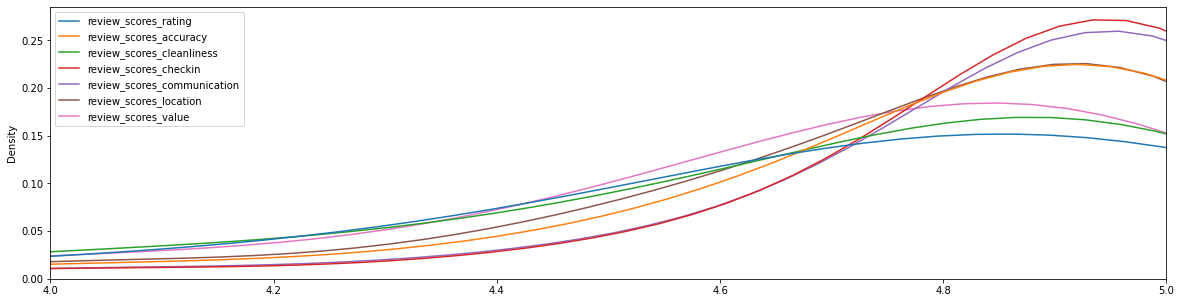

In [ ]:
plt.figure(figsize=(20,5))
sns.kdeplot(data=data_review, color="salmon", bw_adjust=3)
plt.xlim([4.0, 5.0])
plt.show()

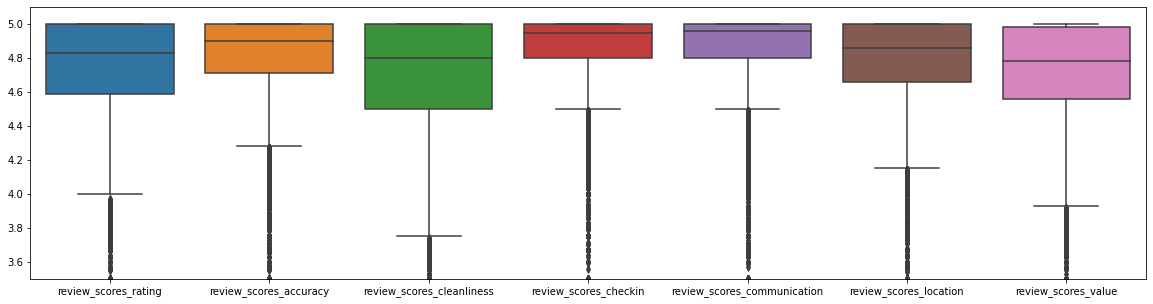

In [ ]:
plt.figure(figsize=(20,5))
sns.boxplot(data=data_review)
plt.ylim([3.5, 5.1])
plt.show()

high correlation:  ['review_scores_rating']


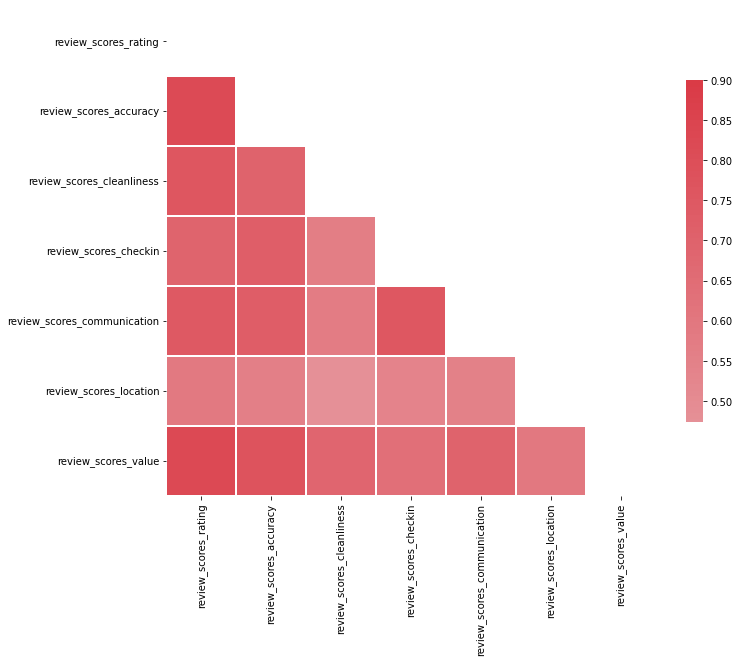

In [ ]:
corr = data_review.corr()
r, c = corr.shape
corr_vals = corr.values
cols_list = list(corr.columns)
h_corr_cols = set()

for i in range(r):
    for j in range(i+1, c):
        if corr_vals[i][j] >= 0.8:
            h_corr_cols.add(cols_list[i])
            
print("high correlation: ", [h for h in h_corr_cols])

mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.9, center=0, square=True, linewidths=.7, cbar_kws={"shrink": .7})
plt.show()

**review_scores_rating**

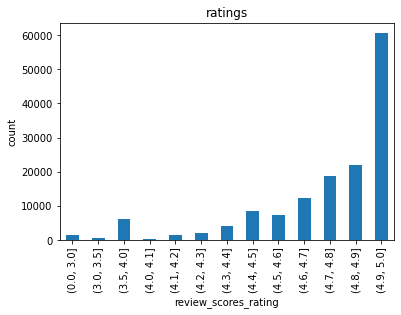

In [ ]:
bins = [0, 3.0, 3.5, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0]
plt_review_scores_rating = data_review["review_scores_rating"].groupby(pd.cut(data_review["review_scores_rating"], bins=bins)).sum()
# plt.figure(figsize=(16,9))
plt.title("ratings")
plt.xlabel("review_scores_rating")
plt.ylabel("count")
plt_review_scores_rating.plot(kind='bar')
plt.show()

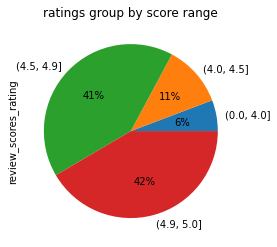

In [ ]:
bins2 = [0, 4.0, 4.5, 4.9, 5.0]
plt_review_scores_rating2 = data_review["review_scores_rating"].groupby(pd.cut(data_review["review_scores_rating"], bins=bins2)).sum()
# plt.figure(figsize=(16,9))
plt.title("ratings group by score range")
plt_review_scores_rating2.plot(subplots=True,kind='pie',autopct='%1.f%%')
plt.show()

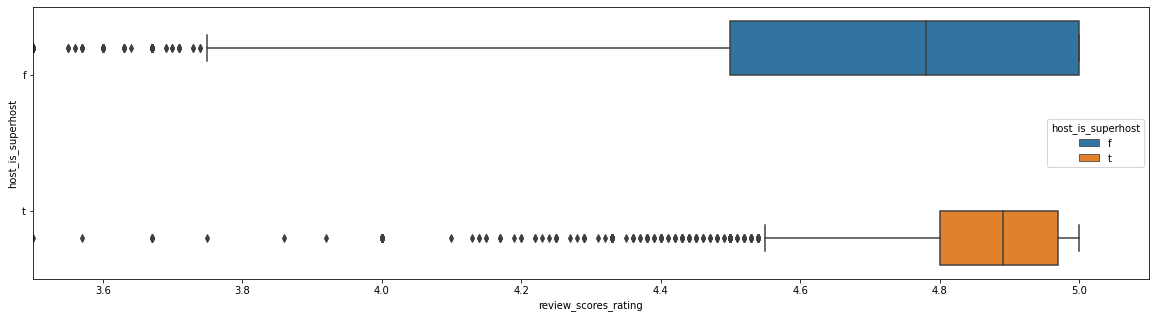

In [ ]:
plt.figure(figsize=(20,5))
sns.boxplot(data=data, x="review_scores_rating", y="host_is_superhost",hue="host_is_superhost")
plt.xlim([3.5, 5.1])
plt.show()

In [ ]:
data[["review_scores_rating","neighbourhood_group_cleansed"]].groupby("neighbourhood_group_cleansed").mean()

,review_scores_rating
neighbourhood_group_cleansed,
Bronx,4.659259
Brooklyn,4.662082
Manhattan,4.587761
Queens,4.631029
Staten Island,4.730289
